# PyTorch Workflow

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.2.1+cu121'



## 1.Data (preparing and loading)



In [2]:
weight = 3.2
bias = 1.5
X = torch.arange(0,1,0.02).unsqueeze(1)
y = weight* X + bias
X[:5],y[:5]


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[1.5000],
         [1.5640],
         [1.6280],
         [1.6920],
         [1.7560]]))

>1.1 Split data into training and test sets

In [3]:
train_size = int(len(X)*0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

1.3 Function for visualizion

In [4]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  # Plot test data in red
  plt.scatter(test_data, test_labels, c='red',s=7, label="Test data")

  if predictions is not None:
    # Plot the predictions in balck (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="black", s=4, label="Predictions")

  # Show the legend(data's label)
  plt.legend(prop={"size": 14});

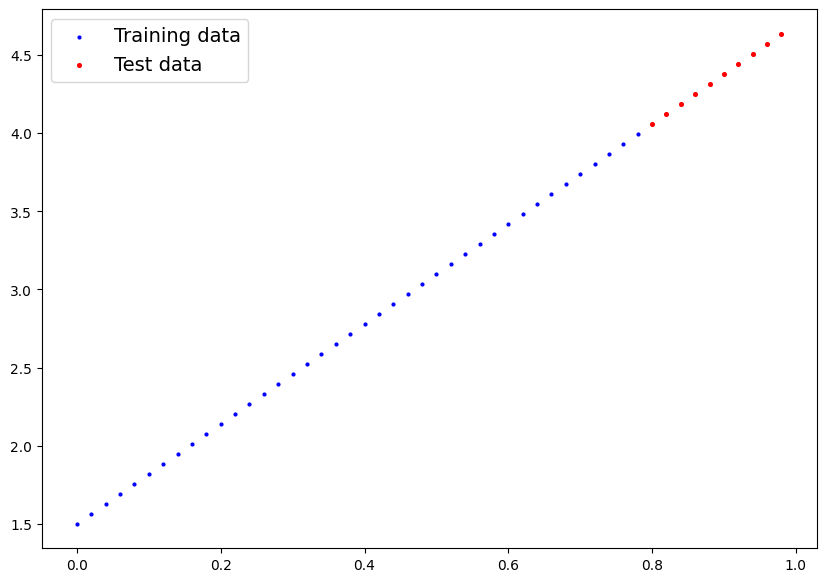

In [5]:
plot_predictions()


## 2.Build a Model

In [6]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer=nn.Linear(in_features=1,out_features=1)
  def forward(self, x: torch.Tensor):
    return self.linear_layer(x)
model_1 = LinearRegressionModel()
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.9751]])),
             ('linear_layer.bias', tensor([0.1446]))])

## 3.Train the Model

In [22]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
#move model to cuda
model_1.to(device)
next(model_1.parameters()).device

Using device: cuda


device(type='cuda', index=0)

In [23]:
#setting
EOPCH=1000
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.1)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

#training
for epoch in range(EOPCH):
  model_1.train()
  # 1.result
  y_pred = model_1(X_train)
  # 2.compare
  loss = loss_fn(y_pred, y_train)
  # 3.clean the history of optimizier
  optimizer.zero_grad()
  # 4.calculate the gradient
  loss.backward()
  # 5.optimizier strat to fix
  optimizer.step()

  ### TESTING
  model_1.eval()
  with torch.inference_mode():
    test_pred=model_1(X_test)
    test_loss=loss_fn(test_pred,y_test)
  if epoch%100==0:
    print(f'epoch:{epoch}---train_loss:{loss},test_loss:{test_loss}')


epoch:0---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:100---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:200---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:300---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:400---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:500---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:600---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:700---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:800---train_loss:0.025485709309577942,test_loss:0.08083529770374298
epoch:900---train_loss:0.025485709309577942,test_loss:0.08083529770374298


In [33]:
dic=model_1.state_dict()
w=dic['linear_layer.weight'].item()
b=dic['linear_layer.bias'].item()
print(f'weight:{w}  bias:{b}')

weight:3.1432220935821533  bias:1.4966577291488647


## 4.Make prediction

In [34]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds##careful it is on gpu

tensor([[4.0112],
        [4.0741],
        [4.1370],
        [4.1998],
        [4.2627],
        [4.3256],
        [4.3884],
        [4.4513],
        [4.5142],
        [4.5770]], device='cuda:0')

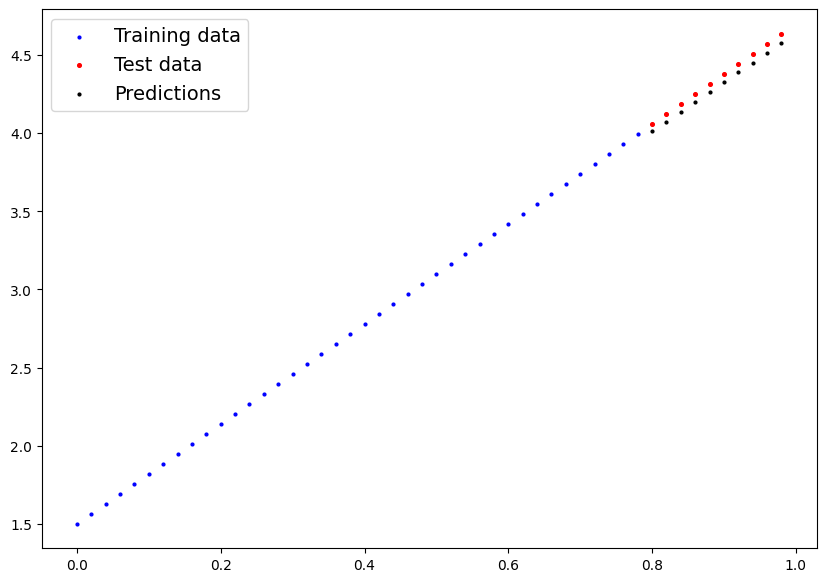

In [35]:
plot_predictions(predictions=y_preds.cpu())

## 5.Saving and loading a model

In [46]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(exist_ok=True)
# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# 3. Save the model state dict

torch.save(obj=model_1.state_dict(), # only saving the state_dict()
           f=MODEL_SAVE_PATH)
print(f"Saving model to: {MODEL_SAVE_PATH}")

Saving model to: models/01_pytorch_workflow_model_1.pth


In [47]:
loaded_model_1=LinearRegressionModel()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

Why don't we test data on loaded Model, see if they are the same as model we trained before?

In [54]:
loaded_model_1.to(device)
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds=loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')